In [1]:
# %pip install matplotlib seaborn scikit-learn

In [2]:
import pandas as pd

In [ ]:
df = pd.read_csv("/home/nahid/Desktop/StockVision/data/processed/all_data.csv")
df.head()

,date,trading_code,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
0,2008-03-06,GLAXOSMITH,260.0,288.3,232.0,241.0,256.6,245.40,170,3.9074,14650
1,2008-03-06,RASPITDATA,0.0,0.0,0.0,3.5,3.5,3.50,0,0.0000,0
2,2008-03-06,PLFSL,302.5,306.0,297.0,297.0,303.5,302.25,108,2.8351,9400
3,2008-03-06,T10Y1016,0.0,0.0,0.0,100000.0,100000.0,100000.00,0,0.0000,0
4,2008-03-06,T20Y1227,0.0,0.0,0.0,100000.0,100000.0,100000.00,0,0.0000,0


In [4]:
df['date'] = pd.to_datetime(df['date'])
data_2020 = df[df['date'].dt.year == 2020]
data_2020.head()

,date,trading_code,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
1458391,2020-01-01,NORTHERN,718.0,733.5,690.0,690.0,719.9,711.0,1572,29.957,41679
1458392,2020-01-01,T5Y0115,0.0,0.0,0.0,0.0,0.0,100000.0,0,0.000,0
1458393,2020-01-01,NLI1STMF,10.6,11.0,10.5,11.0,10.6,10.6,24,0.308,29122
1458394,2020-01-01,T10Y0218,0.0,0.0,0.0,0.0,0.0,100000.0,0,0.000,0
1458395,2020-01-01,T10Y0117,0.0,0.0,0.0,0.0,0.0,100000.0,0,0.000,0


### Data exploration for ML model preparation


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Dataset shape:", df.shape)
print("\nDate range:", df['date'].min(), "to", df['date'].max())
print("\nNumber of unique trading codes:", df['trading_code'].nunique())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (1791069, 11)

Date range: 2008-03-06 00:00:00 to 2022-12-29 00:00:00

Number of unique trading codes: 1007

Data types:
date                        datetime64[ns]
trading_code                        object
last_traded_price                  float64
high                               float64
low                                float64
opening_price                      float64
closing_price                      float64
yesterdays_closing_price           float64
trade                                int64
value_mn                           float64
volume                               int64
dtype: object

Missing values:
date                        0
trading_code                0
last_traded_price           0
high                        0
low                         0
opening_price               0
closing_price               0
yesterdays_closing_price    0
trade                       0
value_mn                    0
volume                      0
dtype: int64


In [6]:
# Data preparation for ML model
# Split data: 2008-2021 for training, 2022 for testing

# Convert date to datetime if not already done
df['date'] = pd.to_datetime(df['date'])

# Create year column for easier filtering
df['year'] = df['date'].dt.year

# Split data by year
train_data = df[df['year'] <= 2021].copy()
test_data = df[df['year'] == 2022].copy()

print(f"Training data shape: {train_data.shape}")
print(f"Training years: {train_data['year'].min()} - {train_data['year'].max()}")
print(f"Test data shape: {test_data.shape}")
print(f"Test years: {test_data['year'].min()} - {test_data['year'].max()}")

# Check if we have 2022 data
if test_data.empty:
    print("\nWarning: No 2022 data found in the dataset!")
    print("Available years:", sorted(df['year'].unique()))
else:
    print(f"\nTraining data: {len(train_data)} records")
    print(f"Test data: {len(test_data)} records")

Training data shape: (1678355, 12)
Training years: 2008 - 2021
Test data shape: (112714, 12)
Test years: 2022 - 2022

Training data: 1678355 records
Test data: 112714 records


In [7]:
# Feature Engineering for Stock Prediction
def create_features(data):
    """Create technical indicators and features for stock prediction"""
    df_features = data.copy()
    
    # Sort by trading_code and date for proper time series features
    df_features = df_features.sort_values(['trading_code', 'date'])
    
    # Technical indicators for each stock
    for code in df_features['trading_code'].unique():
        mask = df_features['trading_code'] == code
        stock_data = df_features[mask].copy()
        
        if len(stock_data) > 1:
            # Price change features
            df_features.loc[mask, 'price_change'] = stock_data['closing_price'].pct_change()
            df_features.loc[mask, 'price_change_abs'] = stock_data['closing_price'].diff()
            
            # Moving averages
            df_features.loc[mask, 'ma_5'] = stock_data['closing_price'].rolling(5).mean()
            df_features.loc[mask, 'ma_10'] = stock_data['closing_price'].rolling(10).mean()
            df_features.loc[mask, 'ma_20'] = stock_data['closing_price'].rolling(20).mean()
            
            # Volatility (rolling standard deviation)
            df_features.loc[mask, 'volatility_5'] = stock_data['closing_price'].rolling(5).std()
            df_features.loc[mask, 'volatility_10'] = stock_data['closing_price'].rolling(10).std()
            
            # Price position relative to high/low
            df_features.loc[mask, 'price_position'] = (stock_data['closing_price'] - stock_data['low']) / (stock_data['high'] - stock_data['low'])
            
            # Lagged features (previous day values)
            df_features.loc[mask, 'prev_close'] = stock_data['closing_price'].shift(1)
            df_features.loc[mask, 'prev_volume'] = stock_data['volume'].shift(1)
            df_features.loc[mask, 'prev_high'] = stock_data['high'].shift(1)
            df_features.loc[mask, 'prev_low'] = stock_data['low'].shift(1)
    
    # Additional features
    df_features['high_low_pct'] = (df_features['high'] - df_features['low']) / df_features['low'] * 100
    df_features['open_close_pct'] = (df_features['closing_price'] - df_features['opening_price']) / df_features['opening_price'] * 100
    
    # Time-based features
    df_features['month'] = df_features['date'].dt.month
    df_features['day_of_week'] = df_features['date'].dt.dayofweek
    df_features['quarter'] = df_features['date'].dt.quarter
    
    return df_features

# Apply feature engineering
print("Creating features for training data...")
train_features = create_features(train_data)
print("Creating features for test data...")
test_features = create_features(test_data)

print(f"Training data with features shape: {train_features.shape}")
print(f"Test data with features shape: {test_features.shape}")

# Display new features
print("\nNew features created:")
new_cols = [col for col in train_features.columns if col not in df.columns]
print(new_cols)

Creating features for training data...
Creating features for test data...
Creating features for test data...
Training data with features shape: (1678355, 29)
Test data with features shape: (112714, 29)

New features created:
['price_change', 'price_change_abs', 'ma_5', 'ma_10', 'ma_20', 'volatility_5', 'volatility_10', 'price_position', 'prev_close', 'prev_volume', 'prev_high', 'prev_low', 'high_low_pct', 'open_close_pct', 'month', 'day_of_week', 'quarter']
Training data with features shape: (1678355, 29)
Test data with features shape: (112714, 29)

New features created:
['price_change', 'price_change_abs', 'ma_5', 'ma_10', 'ma_20', 'volatility_5', 'volatility_10', 'price_position', 'prev_close', 'prev_volume', 'prev_high', 'prev_low', 'high_low_pct', 'open_close_pct', 'month', 'day_of_week', 'quarter']


In [8]:
# Prepare data for Machine Learning
def prepare_ml_data(train_df, test_df, target_col='closing_price'):
    """Prepare data for machine learning models"""
    
    # Select features (exclude non-numeric and target columns)
    exclude_cols = ['date', 'trading_code', target_col, 'year']
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    # Remove rows with NaN values (created by rolling windows and shifts)
    train_clean = train_df.dropna()
    test_clean = test_df.dropna()
    
    # Prepare feature matrices
    X_train = train_clean[feature_cols].copy()
    y_train = train_clean[target_col].copy()
    
    X_test = test_clean[feature_cols].copy()
    y_test = test_clean[target_col].copy()
    
    # Handle infinity values
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    
    # Fill remaining NaN values with median
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())  # Use training median for test
    
    # Remove any remaining NaN or inf values
    train_mask = np.isfinite(X_train).all(axis=1) & np.isfinite(y_train)
    test_mask = np.isfinite(X_test).all(axis=1) & np.isfinite(y_test)
    
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training samples: {X_train_scaled.shape[0]}")
    print(f"Test samples: {X_test_scaled.shape[0]}")
    print(f"Number of features: {X_train_scaled.shape[1]}")
    print(f"Feature columns: {feature_cols}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_cols

# Prepare the data
X_train, X_test, y_train, y_test, scaler, feature_names = prepare_ml_data(train_features, test_features)

print(f"\nTarget variable (closing_price) statistics:")
print(f"Training - Min: {y_train.min():.2f}, Max: {y_train.max():.2f}, Mean: {y_train.mean():.2f}")
print(f"Test - Min: {y_test.min():.2f}, Max: {y_test.max():.2f}, Mean: {y_test.mean():.2f}")

Training samples: 934102
Test samples: 66735
Number of features: 25
Feature columns: ['last_traded_price', 'high', 'low', 'opening_price', 'yesterdays_closing_price', 'trade', 'value_mn', 'volume', 'price_change', 'price_change_abs', 'ma_5', 'ma_10', 'ma_20', 'volatility_5', 'volatility_10', 'price_position', 'prev_close', 'prev_volume', 'prev_high', 'prev_low', 'high_low_pct', 'open_close_pct', 'month', 'day_of_week', 'quarter']

Target variable (closing_price) statistics:
Training - Min: 0.00, Max: 39895.25, Mean: 272.66
Test - Min: 3.80, Max: 5976.10, Mean: 137.88


In [9]:
# Machine Learning Models Implementation
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import time
import joblib
import os

# Create directory for saving models
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate a model"""
    print(f"\n--- {model_name} ---")
    
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
    print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    
    # Save the model
    model_filename = f"{models_dir}/{model_name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, model_filename)
    print(f"Model saved to: {model_filename}")
    
    return {
        'model': model,
        'model_name': model_name,
        'model_path': model_filename,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test,
        'train_time': train_time
    }

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Train and evaluate all models
results = []
print("Training and evaluating models...")

for name, model in models.items():
    try:
        result = evaluate_model(model, X_train, y_train, X_test, y_test, name)
        results.append(result)
    except Exception as e:
        print(f"Error with {name}: {str(e)}")

print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

# Save the scaler as well (important for future predictions)
scaler_path = f"{models_dir}/feature_scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"\nFeature scaler saved to: {scaler_path}")

# Save feature names for future reference
feature_names_path = f"{models_dir}/feature_names.pkl"
joblib.dump(feature_names, feature_names_path)
print(f"Feature names saved to: {feature_names_path}")

Training and evaluating models...

--- Linear Regression ---
Training time: 0.50 seconds
Train MSE: 0.00, Test MSE: 0.00
Train MAE: 0.00, Test MAE: 0.00
Train R²: 1.0000, Test R²: 1.0000
Model saved to: ../models/linear_regression_model.pkl

--- Ridge Regression ---
Training time: 0.50 seconds
Train MSE: 0.00, Test MSE: 0.00
Train MAE: 0.00, Test MAE: 0.00
Train R²: 1.0000, Test R²: 1.0000
Model saved to: ../models/linear_regression_model.pkl

--- Ridge Regression ---
Training time: 0.20 seconds
Train MSE: 689.43, Test MSE: 7.77
Train MAE: 2.85, Test MAE: 1.66
Train R²: 0.9990, Test R²: 1.0000
Model saved to: ../models/ridge_regression_model.pkl

--- Random Forest ---
Training time: 0.20 seconds
Train MSE: 689.43, Test MSE: 7.77
Train MAE: 2.85, Test MAE: 1.66
Train R²: 0.9990, Test R²: 1.0000
Model saved to: ../models/ridge_regression_model.pkl

--- Random Forest ---
Training time: 571.22 seconds
Train MSE: 79.60, Test MSE: 1.46
Train MAE: 0.27, Test MAE: 0.16
Train R²: 0.9999, Test R

              Model     Test MSE     Test MAE  Test R²  Training Time (s)
  Linear Regression 1.022938e-22 8.629230e-12 1.000000           0.497681
      Random Forest 1.456787e+00 1.613065e-01 0.999991         571.217715
      Decision Tree 7.020796e+00 3.157283e-01 0.999958          28.051947
   Ridge Regression 7.768866e+00 1.659488e+00 0.999954           0.199936
  Gradient Boosting 4.646586e+01 2.654147e+00 0.999724         582.072881
K-Nearest Neighbors 3.568926e+02 4.762558e+00 0.997877           0.107415

Best performing model: Linear Regression


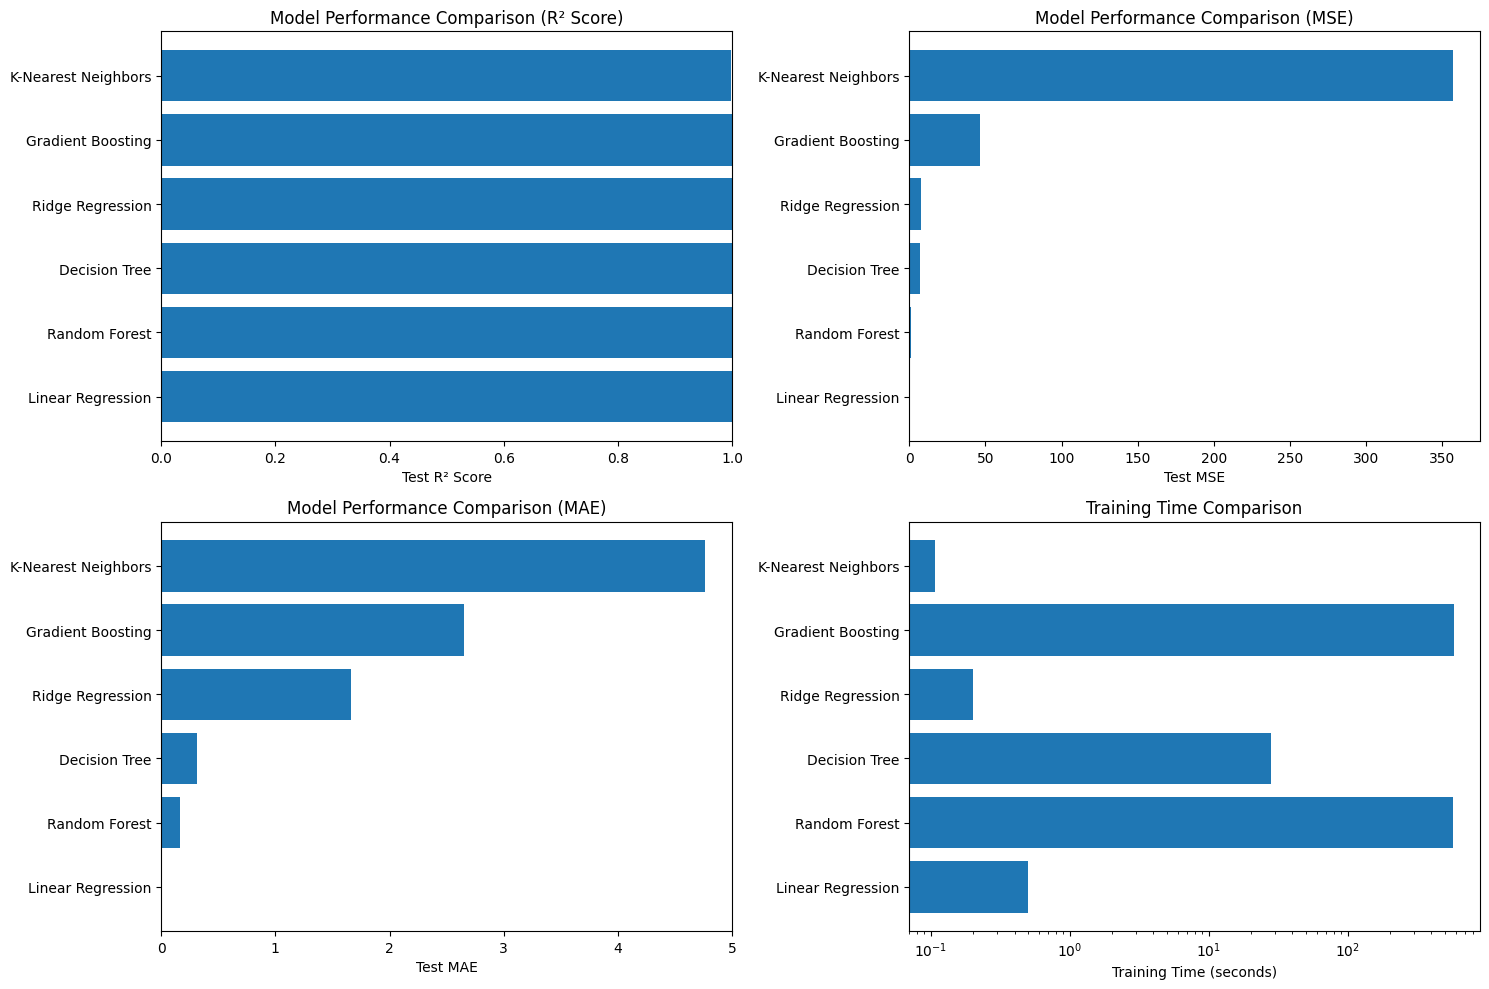


Top 10 Most Important Features (Random Forest):
                 Feature  Importance
       last_traded_price    0.776988
           opening_price    0.084399
                     low    0.058488
                    high    0.038475
                    ma_5    0.030777
yesterdays_closing_price    0.004710
                   ma_10    0.002116
              prev_close    0.000939
                   ma_20    0.000791
          open_close_pct    0.000581


In [10]:
# Model Comparison and Analysis
import pandas as pd

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': [r['model_name'] for r in results],
    'Test MSE': [r['test_mse'] for r in results],
    'Test MAE': [r['test_mae'] for r in results],
    'Test R²': [r['test_r2'] for r in results],
    'Training Time (s)': [r['train_time'] for r in results]
})

# Sort by Test R² (descending)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)
print(comparison_df.to_string(index=False))

# Best model
best_model_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model_name}")

# Visualize results
plt.figure(figsize=(15, 10))

# R² scores comparison
plt.subplot(2, 2, 1)
models_names = comparison_df['Model']
test_r2 = comparison_df['Test R²']
plt.barh(models_names, test_r2)
plt.xlabel('Test R² Score')
plt.title('Model Performance Comparison (R² Score)')
plt.xlim(0, 1)

# MSE comparison
plt.subplot(2, 2, 2)
test_mse = comparison_df['Test MSE']
plt.barh(models_names, test_mse)
plt.xlabel('Test MSE')
plt.title('Model Performance Comparison (MSE)')

# MAE comparison
plt.subplot(2, 2, 3)
test_mae = comparison_df['Test MAE']
plt.barh(models_names, test_mae)
plt.xlabel('Test MAE')
plt.title('Model Performance Comparison (MAE)')

# Training time comparison
plt.subplot(2, 2, 4)
train_time = comparison_df['Training Time (s)']
plt.barh(models_names, train_time)
plt.xlabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.xscale('log')

plt.tight_layout()
plt.show()

# Feature importance for Random Forest (if available)
rf_result = next((r for r in results if r['model_name'] == 'Random Forest'), None)
if rf_result:
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_result['model'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features (Random Forest):")
    print(feature_importance.head(10).to_string(index=False))

In [11]:
# How to Load Saved Models (for future use)
def load_saved_model(model_name):
    """Load a previously saved model"""
    model_filename = f"{models_dir}/{model_name.replace(' ', '_').lower()}_model.pkl"
    try:
        loaded_model = joblib.load(model_filename)
        print(f"Model '{model_name}' loaded successfully from {model_filename}")
        return loaded_model
    except FileNotFoundError:
        print(f"Model file not found: {model_filename}")
        return None

def load_preprocessing_components():
    """Load scaler and feature names"""
    try:
        scaler = joblib.load(f"{models_dir}/feature_scaler.pkl")
        feature_names = joblib.load(f"{models_dir}/feature_names.pkl")
        print("Scaler and feature names loaded successfully")
        return scaler, feature_names
    except FileNotFoundError as e:
        print(f"Preprocessing components not found: {e}")
        return None, None

# Example: Load the best performing model
# best_model = load_saved_model('Random Forest')  # Replace with your best model name
# scaler, feature_names = load_preprocessing_components()

print("Model saving and loading functions are ready!")
print("\nSaved models will be in the '../models/' directory:")
print("- Individual model files (.pkl)")
print("- Feature scaler (.pkl)")  
print("- Feature names list (.pkl)")
print("\nTo use a saved model later:")
print("1. Load the model: model = load_saved_model('Model Name')")
print("2. Load preprocessing: scaler, features = load_preprocessing_components()")
print("3. Scale new data: X_new_scaled = scaler.transform(X_new)")
print("4. Make predictions: predictions = model.predict(X_new_scaled)")

Model saving and loading functions are ready!

Saved models will be in the '../models/' directory:
- Individual model files (.pkl)
- Feature scaler (.pkl)
- Feature names list (.pkl)

To use a saved model later:
1. Load the model: model = load_saved_model('Model Name')
2. Load preprocessing: scaler, features = load_preprocessing_components()
3. Scale new data: X_new_scaled = scaler.transform(X_new)
4. Make predictions: predictions = model.predict(X_new_scaled)
